# LLE calculation for fluid mixtures with SAFT-$\gamma$-Mie

In this notebook, the liquid-liquid equilibria calculations for fluid mixtures with ```saftgammamie``` EoS are illustrated.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS and phase equilibria functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sgtpy import component, mixture, saftgammamie

Now, pure components are configured and created with the ```component``` function. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.


For this notebook, all calculations are exemplified for a mixture of 2-butanol and water.

In [2]:
butanol2 = component(GC={'CH3':2, 'CH2':1, 'CHOH':1})
water = component(GC={'H2O':1})

# creating mixture with mixture class function
mix = mixture(butanol2, water)
# or creating mixture by adding pure components
mix = butanol2 + water

mix.saftgammamie()
eos = saftgammamie(mix)

## LLE calculation

This type of equilibria calculation is carried out at given global composition (z), temperature (K), and pressure (Pa). This calculation can be performed with ```flash``` or ```lle``` function.

The flash calculation is carried out with the ```flash``` function and it requires initial guesses for the phase composition ```x0```, ```w0``` and their aggregation state (```LL``` for liquid/liquid equilibria).

The ```lle``` requires initial guesses for the phase composition ```x0``` and ```w0```.

The ```full_output``` option allows obtaining all the information related to the LLE calculation. This includes the volume of the phases and the solution for the fraction of the nonbonded sites of each phase.

In [3]:
# phase equilibria conditions
T = 350.  # K
P = 1.01325e5  # Pa
z = np.array([0.2, 0.8])

Initial guesses can be obtained from tpd minimization (```tpd_min``` or ```lle_init```). If any tpd < 0, it means that the global phase is unstable at that it will split into two or more phases. 

In [4]:
from sgtpy.equilibrium import tpd_min

# initial guess for the composition of the trial phase
w0 = np.array([0.1, 0.9])
x0, tpx0 = tpd_min(w0, z, T, P, eos, stateW = 'L', stateZ = 'L')
x0, tpx0

(array([0.03974644, 0.96025356]), -0.013396877701859378)

In [5]:
# initial guess for the composition of the trial phase
w0 = np.array([0.5, 0.5])
w0, tpw0 = tpd_min(w0, z, T, P, eos, stateW = 'L', stateZ = 'L')
w0, tpw0

(array([0.4560843, 0.5439157]), -0.011966596068839985)

Once good initial guesses are available, the phase equilibria is computed with the ```flash``` function as follows.

In [6]:
from sgtpy.equilibrium import flash
# initial guesses for aqueous and organic phase composition obtained from tpd minimization
flash(x0, w0, 'LL', z, T, P, eos, full_output=True)

      T: 350.0
      P: 101325.0
   beta: 0.3814952222620302
  error: 9.408778800352845e-09
   iter: 9
      X: array([0.04010833, 0.95989167])
     v1: 2.1312272507286114e-05
  Xass1: array([0.08491351, 0.33458356, 0.11697806, 0.12566356])
 state1: 'L'
      Y: array([0.45922675, 0.54077325])
     v2: 5.246896102137976e-05
  Xass2: array([0.14389972, 0.52138828, 0.1796577 , 0.22258739])
 state2: 'L'
 method: 'ASS'

Similarly, the liquid-liquid equilibria can be computed with the ``lle`` function. This function uses a multiflash algorithm that solves stability and equilibria simultaneously. 
If the ```tetha``` variable is zero, it means that both phases are stable. On the other hand, if it is a positive number it means that the phases are unstable.

In [7]:
from sgtpy.equilibrium import lle

T = 350.  # K
P = 1.01325e5  # Pa
z = np.array([0.2, 0.8])
# initial guesses for aqueous and organic phase composition obtained from tpd minimization
lle(x0, w0, z, T, P, eos, full_output=True)

           T: 350.0
           P: 101325.0
 error_outer: 9.409069677571374e-09
 error_inner: 5.454101111417734e-09
        iter: 8
        beta: array([0.61846376, 0.38153624])
       tetha: array([0.])
           X: array([[0.04010692, 0.95989308],
       [0.45918397, 0.54081603]])
           v: [2.1312272529901016e-05, 5.246896116473695e-05]
        Xass: [array([0.08491351, 0.33458356, 0.11697806, 0.12566356]), array([0.14389972, 0.52138828, 0.1796577 , 0.22258739])]
      states: ['L', 'L']
      method: 'ASS'

## Whole phase diagram calculation

In the following codeblock, the whole phase diagram is computed at constant pressure.
It is advised to store the computed volume roots and nonbonded sites fraction, as these can be used in the following iterations to speed up calculations.

In [8]:
# temperature interval to compute LLE
n = 30
Temp = np.linspace(350, 290, n)

X = np.zeros([2, n])
W = np.zeros([2, n])
vx = np.zeros(n)
vw = np.zeros(n)

# solving the first point
i = 0 
sol = lle(x0, w0, z, Temp[i], P, eos, full_output=True)
X[:, i], W[:, i] = sol.X
vx[i], vw[i] = sol.v

# compute LLE using already computed compositions and volumes as initial guesses
for i in range(1, n):
    Z = (X[:, i-1] + W[:, i-1])/2
    sol = lle(X[:, i-1], W[:, i-1], Z, Temp[i], P, eos, v0=[vx[i-1], vw[i-1]], full_output=True)
    X[:, i], W[:, i] = sol.X
    vx[i], vw[i] = sol.v

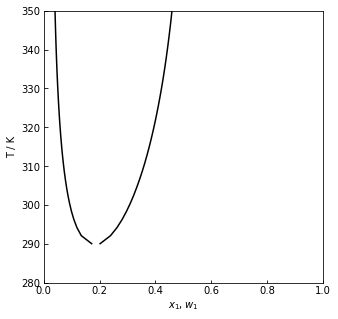

In [9]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(X[0], Temp, color = 'k')
ax.plot(W[0], Temp, color = 'k')
ax.set_xlim([0, 1])
ax.set_ylim([280, 350])
ax.set_xlabel('$x_1, w_1$')
ax.set_ylabel('T / K')
ax.tick_params(direction='in')
# fig.savefig('lle-binary.pdf')

For further information of any of these functions just run: ```function?```